<a href="https://colab.research.google.com/github/graviraja/100-Days-of-NLP/blob/applications%2Fgeneration/applications/generation/image_captioning/Image%20Captioning%20with%20Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Flickr8k Dataset

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ravirajag","key":"3ebe1017281784a1ca4b048c597b0c87"}'}

In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d adityajn105/flickr8k

100% 1.03G/1.04G [00:15<00:00, 70.5MB/s]
100% 1.04G/1.04G [00:15<00:00, 71.3MB/s]


In [6]:
!unzip -qq flickr8k.zip -d flickr8k

In [64]:
!ls flickr8k

captions.txt  Images


### Imports

In [2]:
import os
import time
import nltk
import pickle

import numpy as np

from PIL import Image
from collections import Counter

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.data as data

from torch.nn.utils.rnn import pack_padded_sequence
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Captions

In [5]:
captions = dict()

with open('flickr8k/captions.txt', 'r') as f:
    lines= f.readlines()
    for idx, line in enumerate(lines[1:]):
        index=line.index(',')
        img_id = line[:index].split('.')[0]
        img_caption = line[index+1:].strip()
        captions[idx] = {"image_id": img_id, "caption": img_caption}


In [6]:
len(captions)

40455

In [7]:
captions[90]

{'caption': 'A black dog running in the surf .',
 'image_id': '1022975728_75515238d8'}

### Vocabulary

In [8]:
class Vocabulary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [9]:
def build_vocab(captions_dict, threshold):
    """Build a simple vocabulary wrapper."""
    counter = Counter()
    for i, id in enumerate(captions_dict):
        caption = captions_dict[id]["caption"]
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        counter.update(tokens)

        if (i+1) % 5000 == 0:
            print("[{}/{}] Tokenized the captions.".format(i+1, len(captions_dict)))

    # If the word frequency is less than 'threshold', then the word is discarded.
    words = [word for word, cnt in counter.items() if cnt >= threshold]

    # Create a vocab wrapper and add some special tokens.
    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')

    # Add the words to the vocabulary.
    for i, word in enumerate(words):
        vocab.add_word(word)
    return vocab

In [10]:
vocab = build_vocab(captions, threshold=5)
vocab_path = 'vocab.pkl'
with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f)
print("Total vocabulary size: {}".format(len(vocab)))
print("Saved the vocabulary wrapper to '{}'".format(vocab_path))

[5000/40455] Tokenized the captions.
[10000/40455] Tokenized the captions.
[15000/40455] Tokenized the captions.
[20000/40455] Tokenized the captions.
[25000/40455] Tokenized the captions.
[30000/40455] Tokenized the captions.
[35000/40455] Tokenized the captions.
[40000/40455] Tokenized the captions.
Total vocabulary size: 3006
Saved the vocabulary wrapper to 'vocab.pkl'


### Image Processing

In [76]:
def resize_image(image, size):
    return image.resize(size, Image.ANTIALIAS)

def resize_images(image_dir, output_dir, size):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    images = os.listdir(image_dir)
    num_images = len(images)
    for i, image in enumerate(images):
        with open(os.path.join(image_dir, image), 'r+b') as f:
            with Image.open(f) as img:
                img = resize_image(img, size)
                img.save(os.path.join(output_dir, image), img.format)
        if (i+1) % 1000 == 0:
            print (f"[{i+1}/{num_images}] Resized the images and saved into '{output_dir}'.")
    

In [77]:
image_dir = "flickr8k/Images"
processed_image_dir = "processed_images"
size = [256, 256]

In [80]:
resize_images(image_dir, processed_image_dir, size)

[1000/8091] Resized the images and saved into 'processed_images'.
[2000/8091] Resized the images and saved into 'processed_images'.
[3000/8091] Resized the images and saved into 'processed_images'.
[4000/8091] Resized the images and saved into 'processed_images'.
[5000/8091] Resized the images and saved into 'processed_images'.
[6000/8091] Resized the images and saved into 'processed_images'.
[7000/8091] Resized the images and saved into 'processed_images'.
[8000/8091] Resized the images and saved into 'processed_images'.


### Caption Dataset

In [81]:
class CaptionDataset(data.Dataset):
    def __init__(self, image_dir, annotations, vocab, transform=None):
        self.image_dir = image_dir
        self.annotations = annotations
        self.vocab = vocab
        self.transform = transform
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, item):
        img_id = self.annotations[item]["image_id"]
        caption = self.annotations[item]["caption"]

        image = Image.open(os.path.join(self.image_dir, img_id+'.jpg')).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        
        caption = []
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        
        caption = torch.Tensor(caption)
        return image, caption

In [83]:
# Image preprocessing, normalization for the pretrained resnet
crop_size = 224
transform = transforms.Compose([ 
    transforms.RandomCrop(crop_size),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                            (0.229, 0.224, 0.225))])

In [88]:
train_captions, valid_captions = train_test_split(captions, test_size=0.1, random_state=42)

In [89]:
len(train_captions), len(valid_captions)

(36409, 4046)

In [90]:
image_dir = "processed_images"

train_caption_dataset = CaptionDataset(image_dir, train_captions, vocab, transform)
valid_caption_dataset = CaptionDataset(image_dir, valid_captions, vocab, transform)

### DataLoader

In [91]:
def collate_fn(data):
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths

In [92]:
train_data_loader = torch.utils.data.DataLoader(
    dataset=train_caption_dataset, 
    batch_size=32,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn)

valid_data_loader = torch.utils.data.DataLoader(
    dataset=valid_caption_dataset, 
    batch_size=16,
    shuffle=False,
    collate_fn=collate_fn)

In [103]:
sample = next(iter(train_data_loader))
sample[0].shape, sample[1].shape, len(sample[2])

(torch.Size([32, 3, 224, 224]), torch.Size([32, 19]), 32)

### Encoder

In [11]:
class Encoder(nn.Module):
    def __init__(self, encoded_image_size=14):
        super().__init__()

        resnet = models.resnet101(pretrained=True)

        # remove the linear and pooling layers
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

    
    def forward(self, images):
        # images => [batch_size, 3, 224, 224]
        with torch.no_grad():
            features = self.resnet(images)
            # features => [batch_size, 2048, 7, 7]
        
        pooled = self.adaptive_pool(features)
        # pooled => [batch_size, 2048, encoded_img_size, encoded_img_size]
        #        => [batch_size, 2048, 14, 14]

        out = pooled.permute(0, 2, 3, 1)
        # out => [batch_size, 14, 14, 2048]

        return out

### Attention


In [12]:
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super().__init__()

        self.encoder_attn = nn.Linear(encoder_dim, attention_dim)
        self.decoder_attn = nn.Linear(decoder_dim, attention_dim)
        self.full_attn = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, encoder_out, decoder_hidden):
        enc_attn = self.encoder_attn(encoder_out)
        # enc_attn => [batch_size, num_pixels, attention_dim]

        dec_attn = self.decoder_attn(decoder_hidden)
        # dec_attn => [batch_size, attention_dim]

        attn = self.full_attn(self.relu(enc_attn + dec_attn.unsqueeze(1)))
        # attn => [batch_size, num_pixels, 1]

        attn = attn.squeeze(2)
        # attn => [batch_size, num_pixels]

        alpha = self.softmax(attn)
        # alpha => [batch_size, num_pixels]

        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)
        # attention_weighted_encoding => [batch_size, encoder_dim]

        return attention_weighted_encoding, alpha

### Decoder

In [39]:
class Decoder(nn.Module):
    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=2048, max_seq_length=20, dropout=0.3):
        super().__init__()

        self.vocab_size = vocab_size
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        self.sigmoid = nn.Sigmoid()

        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(decoder_dim, vocab_size)
        self.max_seq_length = max_seq_length
    
    def init_hidden_state(self, encoder_out):
        # encoder_out => [batch_size, num_pixels, encoder_dim]

        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, encoder_out, captions, lengths):
        # encoder_out => [batch_size, enc_image_size, enc_image_size, encoder_dim]
        # captions => [batch_size, max_seq_len]
        # lengths => [batch_size]

        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size

        # flatten image
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)
        num_pixels = encoder_out.size(1)

        embeddings = self.embedding(captions)
        # embeddings => [batch_size, max_seq_len, emb_dim]

        # initialize LSTM state
        h, c = self.init_hidden_state(encoder_out)

        # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
        # So, decoding lengths are actual lengths - 1
        decode_lengths = [length - 1 for length in lengths]

        # Create tensors to hold word predicion scores and alphas
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device)

        # At each time-step, decode by
        # attention-weighing the encoder's output based on the decoder's previous hidden state output
        # then generate a new word in the decoder with the previous word and the attention weighted encoding
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],
                                                                h[:batch_size_t])
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = self.decode_step(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t]))  # (batch_size_t, decoder_dim)
            preds = self.out(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha
        
        return predictions, alphas

    
    def sample(self, encoder_out, captions, end_token, device):
        # encoder_out => [batch_size, enc_image_size, enc_image_size, encoder_dim]
        #             => [1, enc_image_size, enc_image_size, encoder_dim]
        # captions => [1]

        sampled_ids = []
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)

        # flatten image
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)
        num_pixels = encoder_out.size(1)

        # initialize LSTM state
        h, c = self.init_hidden_state(encoder_out)

        # Create tensors to hold word predicion scores and alphas
        sampled_ids = captions
        alphas = torch.zeros(batch_size, self.max_seq_length, num_pixels).to(device)
        
        for t in range(self.max_seq_length):
            caption = torch.LongTensor([sampled_ids[-1]]).to(device)
            embeddings = self.embedding(caption)
            # embeddings => [1, emb_dim]

            attention_weighted_encoding, alpha = self.attention(encoder_out, h)
            gate = self.sigmoid(self.f_beta(h))  # gating scalar, (1, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = self.decode_step(torch.cat([embeddings, attention_weighted_encoding], dim=1), (h, c))
            preds = self.out(self.dropout(h))  # (1, vocab_size)
            _, predicted = preds.max(1)
            alphas[:, t, :] = alpha
            if predicted.item() == end_token:
                break
            sampled_ids.append(predicted.item())

        return sampled_ids, alphas


### Model

In [40]:
embed_dim = 256
decoder_dim = 512
attention_dim = 512

In [108]:
encoder = Encoder().to(device)
decoder = Decoder(attention_dim, embed_dim, decoder_dim, len(vocab)).to(device)

### Loss & Optimizer

In [109]:
criterion = nn.CrossEntropyLoss()

In [110]:
params = list(decoder.parameters()) + list(encoder.adaptive_pool.parameters())
optimizer = torch.optim.Adam(params, lr=0.001)

### Configurations

In [118]:
num_epochs = 2
log_step = 100
model_path = "models"

In [112]:
if not os.path.exists(model_path):
    os.makedirs(model_path)

### Train Method

In [113]:
def train(data_loader, device):

    epoch_loss = 0
    total_steps = len(data_loader)
    encoder.train()
    decoder.train()
    for i, (images, captions, lengths) in enumerate(data_loader):
        images = images.to(device)
        captions = captions.to(device)

        encoded_img = encoder(images)
        predictions, _ = decoder(encoded_img, captions, lengths)

        decode_lengths = [length - 1 for length in lengths]

        outputs = pack_padded_sequence(predictions, decode_lengths, batch_first=True)[0]
        targets = pack_padded_sequence(captions, decode_lengths, batch_first=True)[0]

        loss = criterion(outputs, targets)
        epoch_loss += loss.item()

        decoder.zero_grad()
        encoder.zero_grad()
        loss.backward()
        optimizer.step()

        # Print log info
        if i % log_step == 0:
            print(f'Step [{i}/{total_steps}], Loss: {loss.item():.4f}, Perplexity: {np.exp(loss.item()):5.4f}') 
            
    return epoch_loss / total_steps

### Validation Method

In [114]:
def evaluate(data_loader, device):
    epoch_loss = 0
    total_steps = len(data_loader)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        for i, (images, captions, lengths) in enumerate(data_loader):
            images = images.to(device)
            captions = captions.to(device)

            encoded_img = encoder(images)
            predictions, _ = decoder(encoded_img, captions, lengths)

            decode_lengths = [length - 1 for length in lengths]

            outputs = pack_padded_sequence(predictions, decode_lengths, batch_first=True)[0]
            targets = pack_padded_sequence(captions, decode_lengths, batch_first=True)[0]

            loss = criterion(outputs, targets)
            epoch_loss += loss.item()

            # Print log info
            if i % log_step == 0:
                print(f'Step [{i}/{total_steps}], Loss: {loss.item():.4f}, Perplexity: {np.exp(loss.item()):5.4f}') 
                
    return epoch_loss / total_steps

In [115]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Training

In [119]:
best_valid_loss = float('inf')
for epoch in range(num_epochs):
    
    start_time = time.time()
    train_loss = train(train_data_loader, device)
    val_loss = evaluate(valid_data_loader, device)
    end_time = time.time()

    elapsed_mins, elapsed_secs = epoch_time(start_time, end_time)

    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(decoder.state_dict(), os.path.join(
            model_path, 'decoder-{}.ckpt'.format(epoch+1)))
        torch.save(encoder.state_dict(), os.path.join(
            model_path, 'encoder-{}.ckpt'.format(epoch+1)))
    
    print(f"Epoch: {epoch+1:02} | Time: {elapsed_mins}m {elapsed_secs}s")
    print(f"\t Train Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):5.4f} | Valid Loss: {val_loss:.3f} | Valid PPL: {np.exp(val_loss):5.4f}")

Step [0/1138], Loss: 1.1096, Perplexity: 3.0332
Step [100/1138], Loss: 0.6560, Perplexity: 1.9271
Step [200/1138], Loss: 0.4232, Perplexity: 1.5269
Step [300/1138], Loss: 0.3064, Perplexity: 1.3585
Step [400/1138], Loss: 0.1351, Perplexity: 1.1447
Step [500/1138], Loss: 0.0819, Perplexity: 1.0853
Step [600/1138], Loss: 0.0847, Perplexity: 1.0884
Step [700/1138], Loss: 0.0836, Perplexity: 1.0871
Step [800/1138], Loss: 0.0522, Perplexity: 1.0535
Step [900/1138], Loss: 0.0135, Perplexity: 1.0136
Step [1000/1138], Loss: 0.0396, Perplexity: 1.0404
Step [1100/1138], Loss: 0.0211, Perplexity: 1.0213
Step [0/253], Loss: 0.0261, Perplexity: 1.0265
Step [100/253], Loss: 0.0237, Perplexity: 1.0240
Step [200/253], Loss: 0.0074, Perplexity: 1.0074
Epoch: 01 | Time: 14m 50s
	 Train Loss: 0.212 | Train PPL: 1.2361 | Valid Loss: 0.016 | Valid PPL: 1.0159
Step [0/1138], Loss: 0.0065, Perplexity: 1.0065
Step [100/1138], Loss: 0.0050, Perplexity: 1.0050
Step [200/1138], Loss: 0.0051, Perplexity: 1.0052
S

In [1]:
!ls -lah models

total 421M
drwxr-xr-x 2 root root 4.0K Jul 12 18:19 .
drwxr-xr-x 1 root root 4.0K Jul 12 17:35 ..
-rw-r--r-- 1 root root  48M Jul 12 18:04 decoder-1.ckpt
-rw-r--r-- 1 root root  48M Jul 12 18:19 decoder-2.ckpt
-rw-r--r-- 1 root root 163M Jul 12 18:04 encoder-1.ckpt
-rw-r--r-- 1 root root 163M Jul 12 18:19 encoder-2.ckpt


### Inference

In [147]:
device

device(type='cuda')

In [148]:
vocab_path = "vocab.pkl"
# Load vocabulary wrapper
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

In [41]:
# Build models
encoder = Encoder()
decoder = Decoder(attention_dim, embed_dim, decoder_dim, len(vocab))

In [42]:
encoder.to(device).eval()
decoder.to(device).eval()

Decoder(
  (attention): Attention(
    (encoder_attn): Linear(in_features=2048, out_features=512, bias=True)
    (decoder_attn): Linear(in_features=512, out_features=512, bias=True)
    (full_attn): Linear(in_features=512, out_features=1, bias=True)
    (relu): ReLU()
    (softmax): Softmax(dim=1)
  )
  (embedding): Embedding(3006, 256)
  (decode_step): LSTMCell(2304, 512)
  (init_h): Linear(in_features=2048, out_features=512, bias=True)
  (init_c): Linear(in_features=2048, out_features=512, bias=True)
  (f_beta): Linear(in_features=512, out_features=2048, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=512, out_features=3006, bias=True)
)

In [43]:
encoder_path = "models/encoder-2.ckpt"
decoder_path = "models/decoder-2.ckpt"

# Load the trained model parameters
encoder.load_state_dict(torch.load(encoder_path))
decoder.load_state_dict(torch.load(decoder_path))

<All keys matched successfully>

In [35]:
transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])

In [36]:
def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

In [44]:
def inference(image_path):
    # Prepare an image
    image = load_image(image_path, transform)
    image_tensor = image.to(device)
    # Generate an caption from the image
    encoded_img = encoder(image_tensor)

    initial_caption = [vocab.word2idx['<start>']]
    end_token = vocab.word2idx['<end>']
    sampled_ids, _ = decoder.sample(encoded_img, initial_caption, end_token, device)

    # Convert word_ids to words
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        if word == '<end>':
            break
        sampled_caption.append(word)
    sentence = ' '.join(sampled_caption[1:])

    # Print out the image and the generated caption
    image = Image.open(image_path)
    plt.imshow(np.asarray(image))
    print(sentence)

In [45]:
image_path = "flickr8k/Images/1009434119_febe49276a.jpg"
inference(image_path)

> <ipython-input-39-6d78d3d56615>(96)sample()
-> embeddings = self.embedding(caption)
(Pdb) caption
tensor([1], device='cuda:0')
(Pdb) n
> <ipython-input-39-6d78d3d56615>(99)sample()
-> attention_weighted_encoding, alpha = self.attention(encoder_out, h)
(Pdb) embeddings.shape
torch.Size([1, 256])
(Pdb) n
> <ipython-input-39-6d78d3d56615>(100)sample()
-> gate = self.sigmoid(self.f_beta(h))  # gating scalar, (1, encoder_dim)
(Pdb) attention_weighted_encoding.shape
torch.Size([1, 2048])
(Pdb) n
> <ipython-input-39-6d78d3d56615>(101)sample()
-> attention_weighted_encoding = gate * attention_weighted_encoding
(Pdb) gate.shape
torch.Size([1, 2048])
(Pdb) n
> <ipython-input-39-6d78d3d56615>(102)sample()
-> h, c = self.decode_step(torch.cat([embeddings, attention_weighted_encoding], dim=1), (h, c))
(Pdb) n
> <ipython-input-39-6d78d3d56615>(103)sample()
-> preds = self.out(self.dropout(h))  # (1, vocab_size)
(Pdb) n
> <ipython-input-39-6d78d3d56615>(104)sample()
-> _, predicted = preds.max(1)
(

BdbQuit: ignored

a man climbs a rock .


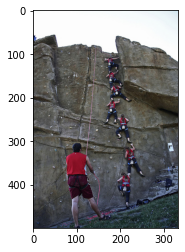

In [ ]:
image_path = "flickr8k/Images/1016887272_03199f49c4.jpg"
inference(image_path)

a black dog is swimming through water .


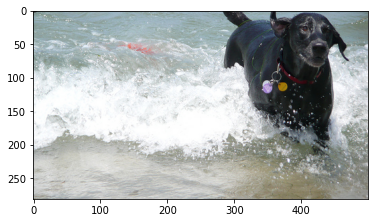

In [ ]:
image_path = "flickr8k/Images/1022975728_75515238d8.jpg"
inference(image_path)